# Riiid Answer Correctness Prediction

## ライブラリのインポート

In [1]:
import numpy as np
import random
import pandas as pd
import joblib
from collections import defaultdict
import lightgbm as lgb
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt
#import riiideducation
from sklearn.metrics import roc_auc_score
import gc

_ = np.seterr(divide='ignore', invalid='ignore')

## ファイル読み込み

In [2]:
cols_to_load = ['timestamp','user_id','content_id',"content_type_id",'task_container_id',
                'answered_correctly','prior_question_elapsed_time','prior_question_had_explanation'] 
target = 'answered_correctly'

train_df = pd.read_csv('train.csv', usecols=cols_to_load)

In [3]:
questions_df = pd.read_csv(
    'questions.csv', 
    usecols=[0, 1,3,4],
    dtype={'question_id': 'int16','bundle_id': 'int16', 'part': 'int8','tags': 'str'}
)

In [4]:
lectures_df = pd.read_csv('lectures.csv')

In [5]:
train_df.head()

,timestamp,user_id,content_id,content_type_id,task_container_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,0,115,5692,0,1,1,NaN,NaN
1,56943,115,5716,0,2,1,37000.0,False
2,118363,115,128,0,0,1,55000.0,False
3,131167,115,7860,0,3,1,19000.0,False
4,137965,115,7922,0,4,1,11000.0,False


In [6]:
questions_df.head()

,question_id,bundle_id,part,tags
0,0,0,1,51 131 162 38
1,1,1,1,131 36 81
2,2,2,1,131 101 162 92
3,3,3,1,131 149 162 29
4,4,4,1,131 5 162 38


In [7]:
lectures_df.head()

,lecture_id,tag,part,type_of
0,89,159,5,concept
1,100,70,1,concept
2,185,45,6,concept
3,192,79,5,solving question
4,317,156,5,solving question


## lectures_df

In [8]:
lectures_df['type_of'] = lectures_df['type_of'].replace('solving question', 'solving_question')
lectures_df = pd.get_dummies(lectures_df, columns=['part', 'type_of'])

part_lectures_columns = [column for column in lectures_df.columns if column.startswith('part')]
types_of_lectures_columns = [column for column in lectures_df.columns if column.startswith('type_of_')]

In [9]:
#user毎の視聴lecture紐付け
train_lectures = train_df[train_df.content_type_id == True].merge(lectures_df, left_on='content_id', right_on='lecture_id', how='left')
train_lectures.head()

,timestamp,user_id,content_id,content_type_id,task_container_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,lecture_id,tag,...,part_2,part_3,part_4,part_5,part_6,part_7,type_of_concept,type_of_intention,type_of_solving_question,type_of_starter
0,653762,2746,6808,1,14,-1,NaN,False,6808,129,...,1,0,0,0,0,0,0,1,0,0
1,10183847,5382,16736,1,21,-1,NaN,False,16736,40,...,0,0,0,0,0,0,1,0,0,0
2,1424348597,5382,30207,1,104,-1,NaN,False,30207,43,...,0,0,0,1,0,0,1,0,0,0
3,1425557777,5382,18545,1,121,-1,NaN,False,18545,58,...,0,0,0,1,0,0,1,0,0,0
4,405813029,8623,10540,1,59,-1,NaN,False,10540,99,...,0,0,0,0,0,0,1,0,0,0


In [10]:
user_lecture_stats_part = train_lectures.groupby('user_id',as_index = False)[part_lectures_columns + types_of_lectures_columns].sum()
lecturedata_types_dict = {   
    'user_id': 'int32', 
    'part_1': 'int8',
    'part_2': 'int8',
    'part_3': 'int8',
    'part_4': 'int8',
    'part_5': 'int8',
    'part_6': 'int8',
    'part_7': 'int8',
    'type_of_concept': 'int8',
    'type_of_intention': 'int8',
    'type_of_solving_question': 'int8',
    'type_of_starter': 'int8'
}
user_lecture_stats_part = user_lecture_stats_part.astype(lecturedata_types_dict)
user_lecture_stats_part.head()

,user_id,part_1,part_2,part_3,part_4,part_5,part_6,part_7,type_of_concept,type_of_intention,type_of_solving_question,type_of_starter
0,2746,0,1,0,0,0,0,0,0,1,0,0
1,5382,1,0,0,0,2,0,0,3,0,0,0
2,8623,2,1,0,0,0,0,0,3,0,0,0
3,12741,0,0,0,3,0,1,2,4,0,2,0
4,13134,1,3,0,0,3,0,0,6,1,0,0


In [11]:
for column in user_lecture_stats_part.columns:
    if(column !='user_id'):
        user_lecture_stats_part[column] = (user_lecture_stats_part[column] > 0).astype('int8')

In [12]:
user_lecture_stats_part.head()

,user_id,part_1,part_2,part_3,part_4,part_5,part_6,part_7,type_of_concept,type_of_intention,type_of_solving_question,type_of_starter
0,2746,0,1,0,0,0,0,0,0,1,0,0
1,5382,1,0,0,0,1,0,0,1,0,0,0
2,8623,1,1,0,0,0,0,0,1,0,0,0
3,12741,0,0,0,1,0,1,1,1,0,1,0
4,13134,1,1,0,0,1,0,0,1,1,0,0


In [13]:
#clearing memory
del(train_lectures)
gc.collect()

51

## train_df

In [14]:
data_types_dict = {
    'timestamp': 'int64',
    'user_id': 'int32', 
    'content_id': 'int16', 
    'content_type_id':'int8', 
    'task_container_id': 'int16',
    'answered_correctly': 'int8', 
    'prior_question_elapsed_time': 'float32', 
    'prior_question_had_explanation': 'boolean'
}

train_df = train_df.astype(data_types_dict)

In [15]:
#content_type_id=1はlecture視聴
#user毎のinteractionの回数、所要時間平均、lecture視聴回数、lexture視聴の総interactionに占める割合算出
cum = train_df.groupby('user_id')['content_type_id'].agg(['cumsum', 'cumcount'])
cum['cumcount']=cum['cumcount']+1
train_df['user_interaction_count'] = cum['cumcount'] 
train_df['user_interaction_timestamp_mean'] = train_df['timestamp']/cum['cumcount'] 
train_df['user_lecture_sum'] = cum['cumsum'] 
train_df['user_lecture_lv'] = cum['cumsum'] / cum['cumcount']

train_df.user_lecture_lv=train_df.user_lecture_lv.astype('float16')
train_df.user_lecture_sum=train_df.user_lecture_sum.astype('int16')
train_df.user_interaction_count=train_df.user_interaction_count.astype('int16')
train_df['user_interaction_timestamp_mean']=train_df['user_interaction_timestamp_mean']/(1000*3600)
train_df.user_interaction_timestamp_mean=train_df.user_interaction_timestamp_mean.astype('float32')


In [16]:
train_df.sample(5)

,timestamp,user_id,content_id,content_type_id,task_container_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,user_interaction_count,user_interaction_timestamp_mean,user_lecture_sum,user_lecture_lv
92911339,3976704306,1970889499,12215,0,1623,1,18000.0,True,2497,0.442387,40,0.016022
1001386,299733,20966550,3363,0,5,1,35667.0,False,10,0.008326,0,0.000000
7367076,35386489,160010677,1367,0,112,1,17000.0,False,160,0.061435,0,0.000000
76838093,10038349363,1636117223,9697,0,5115,1,21000.0,True,6330,0.440510,36,0.005688
63266450,3914060600,1344602051,4236,0,537,0,39000.0,True,619,1.756444,45,0.072693


In [17]:
del cum
gc.collect()

34

In [18]:
train_df.isna().sum()

timestamp                                0
user_id                                  0
content_id                               0
content_type_id                          0
task_container_id                        0
answered_correctly                       0
prior_question_elapsed_time        2351538
prior_question_had_explanation      392506
user_interaction_count                   0
user_interaction_timestamp_mean          0
user_lecture_sum                         0
user_lecture_lv                          0
dtype: int64

In [19]:
train_df['prior_question_had_explanation'].fillna(False, inplace=True)

In [20]:
#lectureの情報削除
train_df = train_df[train_df[target] != -1].reset_index(drop=True)

In [21]:
#part毎の正答率算出
train_df['part'] = train_df['content_id'].map(questions_df['part']).astype('int8')
user_part_correctness_agg = train_df.groupby(["user_id","part"])[target].agg(["mean"]).astype("float16")
user_part_correctness_agg = user_part_correctness_agg.reset_index()
user_part_correctness_agg.rename(columns={"mean":"part_correctness"},inplace=True)

In [22]:
train_df= train_df.merge(user_part_correctness_agg, on=["user_id","part"], how="left")

In [23]:
train_df.drop(columns=["part"], inplace=True)

In [24]:
train_df.head()

,timestamp,user_id,content_id,content_type_id,task_container_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,user_interaction_count,user_interaction_timestamp_mean,user_lecture_sum,user_lecture_lv,part_correctness
0,0,115,5692,0,1,1,NaN,False,1,0.000000,0,0.0,1.000000
1,56943,115,5716,0,2,1,37000.0,False,2,0.007909,0,0.0,1.000000
2,118363,115,128,0,0,1,55000.0,False,3,0.010960,0,0.0,0.702637
3,131167,115,7860,0,3,1,19000.0,False,4,0.009109,0,0.0,0.702637
4,137965,115,7922,0,4,1,11000.0,False,5,0.007665,0,0.0,0.702637


## 解説受講率集計

In [25]:
# content毎の解説視聴有無毎の正答率
content_explanation_agg=train_df[["content_id","prior_question_had_explanation",target]].groupby(["content_id","prior_question_had_explanation"])[target].agg(['mean'])
content_explanation_agg.head()

mean
content_id prior_question_had_explanation          
0          False                           0.830556
           True                            0.911967
1          False                           0.813793
           True                            0.892183
2          False                           0.490938

In [26]:
content_explanation_agg=content_explanation_agg.unstack()
content_explanation_agg=content_explanation_agg.reset_index()
content_explanation_agg.columns = ['content_id', 'content_explanation_false_mean','content_explanation_true_mean']
content_explanation_agg.content_id=content_explanation_agg.content_id.astype('int16')
content_explanation_agg.content_explanation_false_mean=content_explanation_agg.content_explanation_false_mean.astype('float16')
content_explanation_agg.content_explanation_true_mean=content_explanation_agg.content_explanation_true_mean.astype('float16')
content_explanation_agg.head()
# questions_df集計で使用する

,content_id,content_explanation_false_mean,content_explanation_true_mean
0,0,0.830566,0.912109
1,1,0.813965,0.892090
2,2,0.490967,0.562012
3,3,0.686035,0.783691
4,4,0.566895,0.654297


In [27]:
content_had_explanation_agg=train_df.groupby('content_id')['prior_question_had_explanation'].agg(['mean'])
# questions_df集計で使用する

In [28]:
# User毎のexplantion説明視聴率
cum = train_df.groupby('user_id')['prior_question_had_explanation'].agg(['cumsum', 'cumcount'])
cum['cumcount']=cum['cumcount']+1
train_df['explanation_mean'] = cum['cumsum'] / cum['cumcount']
train_df['explanation_true_count'] = cum['cumsum'] 
train_df['explanation_false_count'] =  cum['cumcount']-cum['cumsum']

train_df.explanation_mean=train_df.explanation_mean.astype('float16')
train_df.explanation_true_count=train_df.explanation_true_count.astype('int16')
train_df.explanation_false_count=train_df.explanation_false_count.astype('int16')

In [29]:
del cum
gc.collect()

51

## attempt_noの作成

In [30]:
#同じ質問への回答回数集計
train_df["attempt_no"] = 1
train_df.attempt_no = train_df.attempt_no.astype('int8')

attempt_no_agg = train_df.groupby(["user_id","content_id"])["attempt_no"].agg(['sum']).astype('int8')
train_df["attempt_no"] = train_df[["user_id","content_id",'attempt_no']].groupby(["user_id","content_id"])["attempt_no"].cumsum()

In [31]:
#attempt_no_agg=attempt_no_agg.reset_index()
attempt_no_agg=attempt_no_agg[attempt_no_agg['sum'] >1]

## timestampの集計

In [32]:
#前門への回答の所要時間算出
train_df['lagtime'] = train_df.groupby('user_id')['timestamp'].shift()
train_df['lagtime'] = train_df['timestamp']-train_df['lagtime']
lagtime_mean = train_df['lagtime'].mean()
train_df['lagtime'].fillna(lagtime_mean, inplace=True)
train_df['lagtime'] = train_df['lagtime']/(1000*3600)
train_df.lagtime = train_df.lagtime.astype('float32')

In [33]:
#前門２門への回答の所要時間算出
train_df['lagtime2'] = train_df.groupby('user_id')['timestamp'].shift(2)
train_df['lagtime2'] = train_df['timestamp']-train_df['lagtime2']
lagtime_mean2 = train_df['lagtime2'].mean()
train_df['lagtime2'].fillna(lagtime_mean2, inplace=True)
train_df['lagtime2'] = train_df['lagtime2']/(1000*3600)
train_df.lagtime2 = train_df.lagtime2.astype('float32')

In [34]:
#前門3門への回答の所要時間算出
train_df['lagtime3'] = train_df.groupby('user_id')['timestamp'].shift(3)
train_df['lagtime3'] = train_df['timestamp']-train_df['lagtime3']
lagtime_mean3 = train_df['lagtime3'].mean()
train_df['lagtime3'].fillna(lagtime_mean3, inplace=True)
train_df['lagtime3'] = train_df['lagtime3']/(1000*3600)
train_df.lagtime3 = train_df.lagtime3.astype('float32')

In [35]:
train_df['timestamp']=train_df['timestamp']/(1000*3600)
train_df.timestamp=train_df.timestamp.astype('float32')

## prior_question_elapsed_timeの集計

In [36]:
#欠損値処理(平均)
prior_question_elapsed_time_mean=train_df['prior_question_elapsed_time'].mean()
train_df['prior_question_elapsed_time'].fillna(prior_question_elapsed_time_mean, inplace=True)
train_df['prior_question_elapsed_time']=train_df['prior_question_elapsed_time']/(1000*3600)

In [37]:
user_prior_question_elapsed_time = train_df[['user_id','prior_question_elapsed_time']].groupby(['user_id']).tail(1)
user_prior_question_elapsed_time.columns = ['user_id', 'prior_question_elapsed_time']

In [38]:
#delta算出
train_df['delta_prior_question_elapsed_time'] = train_df.groupby('user_id')['prior_question_elapsed_time'].shift()
train_df['delta_prior_question_elapsed_time']=train_df['prior_question_elapsed_time']-train_df['delta_prior_question_elapsed_time']

In [39]:
#欠損値処理
delta_prior_question_elapsed_time_mean=train_df['delta_prior_question_elapsed_time'].mean()
train_df['delta_prior_question_elapsed_time'].fillna(delta_prior_question_elapsed_time_mean, inplace=True)
train_df.delta_prior_question_elapsed_time=train_df.delta_prior_question_elapsed_time.astype('float32')

In [40]:
content_elapsed_time_agg=train_df.groupby('content_id')['prior_question_elapsed_time'].agg(['mean'])
# questions_df集計で使用する

## 正答率集計

In [41]:
#user毎の正答率、正答数、不正答数
train_df['lag'] = train_df.groupby('user_id')[target].shift()
cum = train_df.groupby('user_id')['lag'].agg(['cumsum', 'cumcount'])
user_agg = train_df.groupby('user_id')['lag'].agg(['sum', 'count']).astype('int16')
cum['cumsum'].fillna(0, inplace=True)

train_df['user_correctness'] = cum['cumsum'] / cum['cumcount']
train_df['user_correct_count'] = cum['cumsum']
train_df['user_uncorrect_count'] = cum['cumcount']-cum['cumsum']

train_df.drop(columns=['lag'], inplace=True)
train_df['user_correctness'].fillna(0, inplace=True)
train_df.user_correctness=train_df.user_correctness.astype('float16')
train_df.user_correct_count=train_df.user_correct_count.astype('int16')
train_df.user_uncorrect_count=train_df.user_uncorrect_count.astype('int16')

In [42]:
del cum
gc.collect()

34

In [43]:
#task_container毎の集計
task_container_agg = train_df.groupby('task_container_id')[target].agg(['sum', 'count','var'])
task_container_agg=task_container_agg.astype('float32')

train_df['task_container_uncor_count'] = train_df['task_container_id'].map(task_container_agg['count']-task_container_agg['sum']).astype('int32')
train_df['task_container_cor_count'] = train_df['task_container_id'].map(task_container_agg['sum']).astype('int32')
train_df['task_container_std'] = train_df['task_container_id'].map(task_container_agg['var']).astype('float16')
train_df['task_container_correctness'] = train_df['task_container_id'].map(task_container_agg['sum'] / task_container_agg['count']).astype('float16')

In [44]:
train_df.dtypes

timestamp                            float32
user_id                                int32
content_id                             int16
content_type_id                         int8
task_container_id                      int16
answered_correctly                      int8
prior_question_elapsed_time          float64
prior_question_had_explanation       boolean
user_interaction_count                 int16
user_interaction_timestamp_mean      float32
user_lecture_sum                       int16
user_lecture_lv                      float16
part_correctness                     float16
explanation_mean                     float16
explanation_true_count                 int16
explanation_false_count                int16
attempt_no                              int8
lagtime                              float32
lagtime2                             float32
lagtime3                             float32
delta_prior_question_elapsed_time    float32
user_correctness                     float16
user_corre

In [45]:
train_df.head()

,timestamp,user_id,content_id,content_type_id,task_container_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,user_interaction_count,user_interaction_timestamp_mean,...,lagtime2,lagtime3,delta_prior_question_elapsed_time,user_correctness,user_correct_count,user_uncorrect_count,task_container_uncor_count,task_container_cor_count,task_container_std,task_container_correctness
0,0.000000,115,5692,0,1,1,0.007062,False,1,0.000000,...,11.214070,16.669001,-0.000001,0.0,0,0,187175,208704,0.249268,0.527344
1,0.015818,115,5716,0,2,1,0.010278,False,2,0.007909,...,11.214070,16.669001,0.003216,1.0,1,0,223198,172342,0.245850,0.435791
2,0.032879,115,128,0,0,1,0.015278,False,3,0.010960,...,0.032879,16.669001,0.005000,1.0,2,0,126682,269233,0.217651,0.680176
3,0.036435,115,7860,0,3,1,0.005278,False,4,0.009109,...,0.020618,0.036435,-0.010000,1.0,3,0,180574,214721,0.248169,0.542969
4,0.038324,115,7922,0,4,1,0.003056,False,5,0.007665,...,0.005445,0.022506,-0.002222,1.0,4,0,361957,330079,0.249512,0.477051


## questions_df

In [46]:
questions_df.head()

,question_id,bundle_id,part,tags
0,0,0,1,51 131 162 38
1,1,1,1,131 36 81
2,2,2,1,131 101 162 92
3,3,3,1,131 149 162 29
4,4,4,1,131 5 162 38


In [47]:
questions_df.isna().sum()

question_id    0
bundle_id      0
part           0
tags           1
dtype: int64

In [48]:
questions_df.rename(columns={'question_id':'content_id'}, inplace=True)

In [49]:
questions_df['tags'].fillna('188', inplace=True)

In [50]:
# tag情報抽出
def gettags(tags,num):
    tags_splits=tags.split(" ")
    result='' 
    for t in tags_splits:
        x=int(t)
        if(x<32*(num+1) and x>=32*num):#num 
            result=result+' '+t
    return result

In [51]:
from sklearn.preprocessing import LabelEncoder
for num in range(0,6):
    questions_df["tags"+str(num)] = questions_df["tags"].apply(lambda row: gettags(row,num))
    le = LabelEncoder()
    le.fit(np.unique(questions_df['tags'+str(num)].values))
    questions_df['tags'+str(num)]=questions_df[['tags'+str(num)]].apply(le.transform)

In [52]:
questions_df_dict = {   
    'tags0': 'int8',
    'tags1': 'int8',
    'tags2': 'int8',
    'tags3': 'int8',
    'tags4': 'int8',
    'tags5': 'int8',
}
questions_df = questions_df.astype(questions_df_dict)

In [53]:
questions_df.drop(columns=['tags'], inplace=True)

In [54]:
questions_df.head()

,content_id,bundle_id,part,tags0,tags1,tags2,tags3,tags4,tags5
0,0,0,1,0,34,0,0,4,10
1,1,1,1,0,6,44,0,4,0
2,2,2,1,0,0,77,3,4,10
3,3,3,1,43,0,0,0,6,10
4,4,4,1,49,9,0,0,4,10


In [55]:
#content毎の説明有無毎の正答率
questions_df = pd.merge(questions_df, content_explanation_agg, on='content_id', how='left')#

In [56]:
del content_explanation_agg

In [57]:
#content毎の正答率
content_agg = train_df.groupby('content_id')[target].agg(['sum', 'count','var'])
content_agg=content_agg.astype('float32')

In [58]:
questions_df['content_correctness'] = questions_df['content_id'].map(content_agg['sum'] / content_agg['count'])
questions_df.content_correctness = questions_df.content_correctness.astype('float16')
questions_df['content_correctness_std'] = questions_df['content_id'].map(content_agg['var'])
questions_df.content_correctness_std = questions_df.content_correctness_std.astype('float16')
questions_df['content_uncorrect_count'] = questions_df['content_id'].map(content_agg['count']-content_agg['sum']).astype('float32')
questions_df['content_correct_count'] = questions_df['content_id'].map(content_agg['sum']).astype('float32')

In [59]:
#content毎のelapsed_time平均と説明視聴率
questions_df['content_elapsed_time_mean'] = questions_df['content_id'].map(content_elapsed_time_agg['mean'])
questions_df.content_elapsed_time_mean=questions_df.content_elapsed_time_mean.astype('float16')
questions_df['content_had_explanation_mean'] = questions_df['content_id'].map(content_had_explanation_agg['mean'])
questions_df.content_had_explanation_mean=questions_df.content_had_explanation_mean.astype('float16')

In [60]:
del content_elapsed_time_agg
del content_had_explanation_agg
gc.collect()

136

In [61]:
# Part毎の正答率、正答数、不正解数
part_agg = questions_df.groupby('part')['content_correctness'].agg(['mean', 'var'])
questions_df['part_correctness_mean'] = questions_df['part'].map(part_agg['mean'])
questions_df['part_correctness_std'] = questions_df['part'].map(part_agg['var'])
questions_df.part_correctness_mean=questions_df.part_correctness_mean.astype('float16')
questions_df.part_correctness_std=questions_df.part_correctness_std.astype('float16')

In [62]:
part_agg = questions_df.groupby('part')['content_uncorrect_count'].agg(['sum'])
questions_df['part_uncor_count'] = questions_df['part'].map(part_agg['sum']).astype('int32')
part_agg = questions_df.groupby('part')['content_correct_count'].agg(['sum'])
questions_df['part_cor_count'] = questions_df['part'].map(part_agg['sum']).astype('int32')

In [63]:
# bundle_id毎の正答率、正答数、不正解数
bundle_agg = questions_df.groupby('bundle_id')['content_correctness'].agg(['mean'])
questions_df['bundle_correctness_mean'] = questions_df['bundle_id'].map(bundle_agg['mean'])
questions_df.bundle_correctness_mean=questions_df.bundle_correctness_mean.astype('float16')

In [64]:
#'part_pq_elapsed_time_rate'：part1-7で読解問題であるpart6,7の所要時間が長いことが想定されるため、part毎の所要時間で補正
content_pq_elapsed_time_agg = train_df.groupby("content_id")["prior_question_elapsed_time"].agg(["mean"])
content_pq_elapsed_time_agg = content_pq_elapsed_time_agg.astype("int32")

In [65]:
questions_df['content_pq_elapsed_time_mean'] = questions_df['content_id'].map(content_pq_elapsed_time_agg['mean'])
questions_df.content_pq_elapsed_time_mean=questions_df.content_pq_elapsed_time_mean.astype('float32')

In [66]:
part_pq_elapsed_time_agg = questions_df.groupby("part")["content_pq_elapsed_time_mean"].agg(["mean"])
part_pq_elapsed_time_agg = part_pq_elapsed_time_agg.astype("float32")

In [67]:
questions_df['part_pq_elapsed_time_mean'] = questions_df['part'].map(part_pq_elapsed_time_agg['mean'])
questions_df.part_pq_elapsed_time_mean=questions_df.part_pq_elapsed_time_mean.astype('float32')

In [68]:
questions_df['part_pq_elapsed_time_rate'] = questions_df['content_pq_elapsed_time_mean']/questions_df['part_pq_elapsed_time_mean']
questions_df.part_pq_elapsed_time_rate=questions_df.part_pq_elapsed_time_rate.astype('float16')
questions_df.drop(columns=['content_pq_elapsed_time_mean','part_pq_elapsed_time_mean'],inplace=True)

In [69]:
del content_pq_elapsed_time_agg
del part_pq_elapsed_time_agg
del content_agg
del bundle_agg
del part_agg
gc.collect()

119

In [70]:
questions_df.fillna(0, inplace=True)

In [71]:
questions_df.dtypes

content_id                          int16
bundle_id                           int16
part                                 int8
tags0                                int8
tags1                                int8
tags2                                int8
tags3                                int8
tags4                                int8
tags5                                int8
content_explanation_false_mean    float16
content_explanation_true_mean     float16
content_correctness               float16
content_correctness_std           float16
content_uncorrect_count           float32
content_correct_count             float32
content_elapsed_time_mean         float16
content_had_explanation_mean      float16
part_correctness_mean             float16
part_correctness_std              float16
part_uncor_count                    int32
part_cor_count                      int32
bundle_correctness_mean           float16
part_pq_elapsed_time_rate         float16
dtype: object

In [72]:
questions_df.head()

,content_id,bundle_id,part,tags0,tags1,tags2,tags3,tags4,tags5,content_explanation_false_mean,...,content_uncorrect_count,content_correct_count,content_elapsed_time_mean,content_had_explanation_mean,part_correctness_mean,part_correctness_std,part_uncor_count,part_cor_count,bundle_correctness_mean,part_pq_elapsed_time_rate
0,0,0,1,0,34,0,0,4,10,0.830566,...,637.0,6266.0,0.006077,0.947754,0.814941,0.021591,1900674,5553896,0.907715,0.0
1,1,1,1,0,6,44,0,4,0,0.813965,...,809.0,6589.0,0.006138,0.980469,0.814941,0.021591,1900674,5553896,0.890625,0.0
2,2,2,1,0,0,77,3,4,10,0.490967,...,20015.0,24890.0,0.006542,0.888184,0.814941,0.021591,1900674,5553896,0.554199,0.0
3,3,3,1,43,0,0,0,6,10,0.686035,...,5067.0,17906.0,0.006477,0.958496,0.814941,0.021591,1900674,5553896,0.779297,0.0
4,4,4,1,49,9,0,0,4,10,0.566895,...,12275.0,19461.0,0.006424,0.530273,0.814941,0.021591,1900674,5553896,0.613281,0.0


## Train_Valids

In [73]:
features_dict = {
    #'user_id',
    'timestamp':'float16',
    'user_interaction_count':'int16',
    'user_interaction_timestamp_mean':'float32',
    'lagtime':'float32',
    'lagtime2':'float32',
    'lagtime3':'float32',
    #'content_id':'int16',
    #'task_container_id':'int16',
    'user_lecture_sum':'int16',
    'user_lecture_lv':'float16',
    'prior_question_had_explanation':'int8',
    'explanation_mean':'float16',
    'explanation_false_count':'int16',
    'explanation_true_count':'int16',
    'prior_question_elapsed_time':'float32',
    'delta_prior_question_elapsed_time':'int32',
    'user_correctness':'float16',
    "part_correctness":"float16",
    'user_uncorrect_count':'int16',
    'user_correct_count':'int16',
    #'content_correctness':'float16',
    'content_correctness_std':'float16',
    'content_correct_count':'int32',
    'content_uncorrect_count':'int32',
    'content_elapsed_time_mean':'float16',
    'part_pq_elapsed_time_rate':'float16',
    'content_had_explanation_mean':'float16',
    'content_explanation_false_mean':'float16',
    'content_explanation_true_mean':'float16',
    'task_container_correctness':'float16',
    'task_container_std':'float16',
    'task_container_cor_count':'int32',
    'task_container_uncor_count':'int32',
    'attempt_no':'int8',
    'part':'int8',
    'part_correctness_mean':'float16',
    'part_correctness_std':'float16',
    'part_uncor_count':'int32',
    'part_cor_count':'int32',
    'tags0': 'int8',
    'tags1': 'int8',
    'tags2': 'int8',
    'tags3': 'int8',
    'tags4': 'int8',
    'tags5': 'int8',
    #'bundle_id':'int16',
    'bundle_correctness_mean':'float16',
    
# lecture_dataは精度低下のため不採用
#     'part_1',
#     'part_2',
#     'part_3',
#     'part_4',
#     'part_5',
#     'part_6',
#     'part_7',
#     'type_of_concept',
#     'type_of_intention',
#     'type_of_solving_question',
#     'type_of_starter'
}

features=list(features_dict.keys())


In [74]:
flag_lgbm=True
clfs = list()
params = {
'num_leaves': 200,
'max_bin':450,
'feature_fraction': 0.52,
'bagging_fraction': 0.52,
'objective': 'binary',
'learning_rate': 0.05,
"boosting_type": "gbdt",
"metric": 'auc',
 'random_state': 47
}
trains=list()
valids=list()
num=1
random.seed(123)
for i in range(0,num):
    
    train_df_clf=train_df.sample(n=1200*10000)
    print('sample end')
    
    users=train_df_clf['user_id'].drop_duplicates()#
    users=users.sample(frac=0.08)
    users_df=pd.DataFrame()
    users_df['user_id']=users.values
    valid_df_newuser = pd.merge(train_df_clf, users_df, on=['user_id'], how='inner')

    del users_df
    del users
    gc.collect()
    
    valid_df_newuser.set_index("user_id", inplace=True)
    train_df_clf.set_index("user_id", inplace=True)
    train_df_clf.drop(valid_df_newuser.index.unique(), inplace=True)
    print('pd.merge(train_df_clf, questions_df)')
    
    train_df_clf = pd.merge(train_df_clf, questions_df, on='content_id', how='left')
    valid_df_newuser = pd.merge(valid_df_newuser, questions_df, on='content_id', how='left')
    
    print('valid_df')
    valid_df=train_df_clf.sample(frac=0.1)
    train_df_clf.drop(valid_df.index, inplace=True)
   
    valid_df = valid_df.append(valid_df_newuser)
    del valid_df_newuser
    gc.collect()

    trains.append(train_df_clf)
    valids.append(valid_df)
    print('train_df_clf length：',len(train_df_clf))
    print('valid_df length：',len(valid_df))

sample end
pd.merge(train_df_clf, questions_df)
valid_df
train_df_clf length： 9926631
valid_df length： 2073369


In [75]:
#del train_df
del train_df_clf
del valid_df
gc.collect()

17

[LightGBM] [Info] Number of positive: 6520435, number of negative: 3406196
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.384545 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12831
[LightGBM] [Info] Number of data points in the train set: 9926631, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.656863 -> initscore=0.649345
[LightGBM] [Info] Start training from score 0.649345
Training until validation scores don't improve for 50 rounds
[50]	training's auc: 0.782741	valid_1's auc: 0.783086
[100]	training's auc: 0.788586	valid_1's auc: 0.788567
[150]	training's auc: 0.791202	valid_1's auc: 0.790841
[200]	training's auc: 0.792638	valid_1's auc: 0.791906
[250]	training's auc: 0.793754	valid_1's auc: 0.792633
[300]	training's auc: 0.794624	valid_1's auc: 0.793101
[350]	training's auc: 0.795219	valid_1's auc

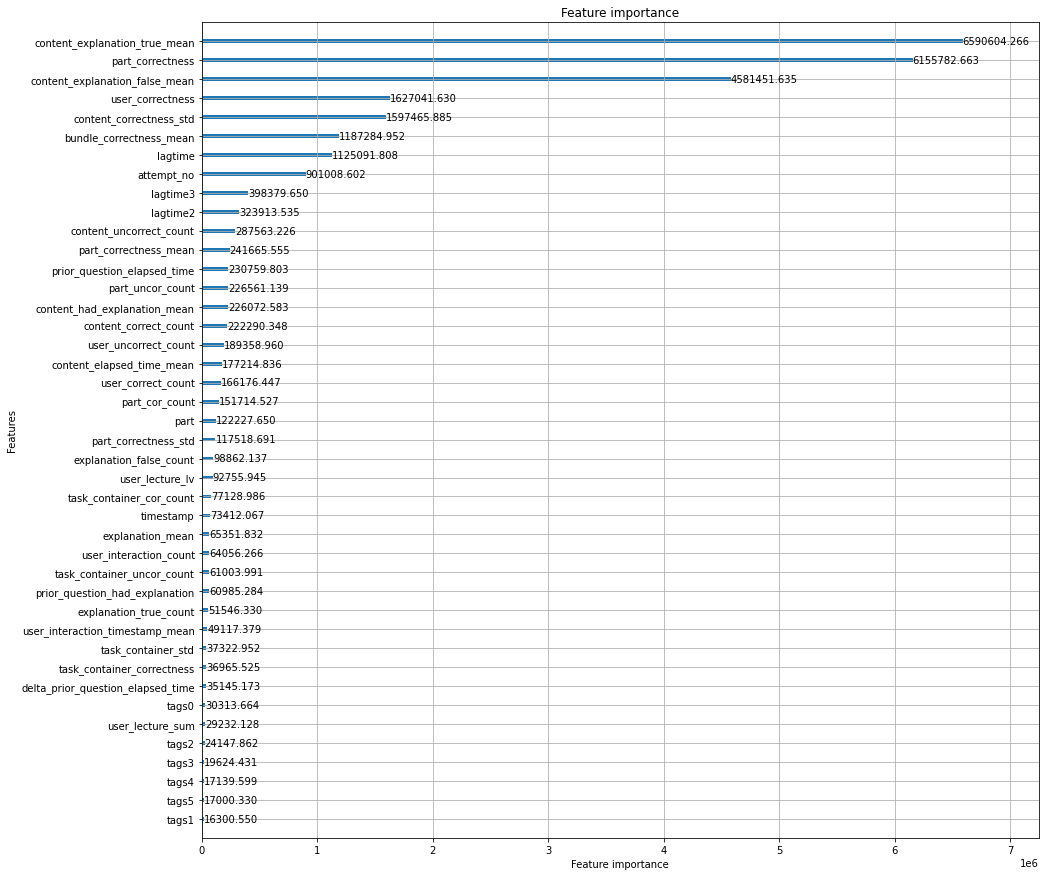

In [76]:

for i in range(0,num):
      
    X_train_np = trains[i][features].values.astype(np.float32)
    X_valid_np = valids[i][features].values.astype(np.float32)
    tr_data = lgb.Dataset(X_train_np, label=trains[i][target], feature_name=list(features))
    va_data = lgb.Dataset(X_valid_np, label=valids[i][target], feature_name=list(features))
    
    del trains
    del valids
    del X_train_np
    del X_valid_np
    gc.collect()

    model = lgb.train(
        params, 
        tr_data,
        num_boost_round=500,
        valid_sets=[tr_data, va_data],
        early_stopping_rounds=50,
        feature_name=features,
        verbose_eval=50
    )
    clfs.append(model)

    fig,ax = plt.subplots(figsize=(15,15))
    lgb.plot_importance(model, ax=ax,importance_type='gain',max_num_features=50)
    plt.show()

    del tr_data
    del va_data
    gc.collect()


#### Time-series APIでテストデータから予測しSubmission(コード省略)